# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
###########################################
# Suppress matplotlib user warnings
# Necessary for newer version of matplotlib
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
#
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################

# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# added libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import Imputer

import matplotlib.image as mpimg
import matplotlib.cm as cm

from IPython.display import display

# magic word for producing visualizations in notebook
%matplotlib inline
import random


'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.shape


(891221, 85)

In [4]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,1,1976,12.0,0,3,2.0,1.0,1.0,1.0,2.0,1.0,1,14,3.0,2,1,3,3,2,1,6,3,4,4,7,5,4,2,3,0.0,0.0,1,4,17.0,1.0,0.0,4.0,3.0,3.0,4.0,15.0,0.0,8.0,3.0,1992.0,W,3.0,7,7A,41,2.0,1.0,0.0,0.0,0.0,4.0,6.0,3.0,7.0,4.0,3.0,5.0,5.0,5.0,282.0,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,6,1970,1.0,0,-1,2.0,1.0,1.0,1.0,1.0,1.0,0,10,5.0,4,4,7,5,4,7,7,4,4,4,4,4,6,2,-1,0.0,0.0,-1,6,16.0,1.0,0.0,6.0,NaN,6.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,5.0,9,9D,51,0.0,0.0,1.0,1.0,5.0,2.0,7.0,6.0,2.0,3.0,3.0,1.0,2.0,7.0,592.0,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,1,1976,10.0,0,1,0.0,0.0,0.0,0.0,4.0,2.0,1,14,4.0,5,2,5,3,2,3,5,5,7,4,4,5,6,7,2,0.0,0.0,1,4,17.0,0.0,0.0,5.0,NaN,NaN,5.0,3.0,0.0,8.0,6.0,1992.0,W,7.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,5.0,2.0,6.0,4.0,3.0,2.0,3.0,5.0,688.0,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,1,1994,9.0,0,1,29.0,9.0,9.0,5.0,2.0,1.0,1,14,4.0,7,7,7,5,6,3,2,7,5,2,2,2,7,5,0,0.0,0.0,2,5,0.0,1.0,0.0,6.0,NaN,1.0,9.0,7.0,0.0,8.0,2.0,1992.0,W,5.0,9,9D,51,0.0,3.0,2.0,0.0,0.0,3.0,2.0,6.0,4.0,4.0,4.0,1.0,3.0,7.0,134.0,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,6,0,12.0,0,2,6.0,2.0,1.0,1.0,1.0,1.0,1,3,1.0,6,6,3,4,6,5,3,6,3,3,3,2,2,2,2,0.0,0.0,1,3,0.0,1.0,0.0,5.0,NaN,6.0,3.0,10.0,0.0,8.0,3.0,1992.0,W,4.0,6,6B,43,1.0,3.0,1.0,1.0,0.0,2.0,6.0,2.0,8.0,4.0,4.0,3.0,0.0,6.0,728.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

### AZDIAS Demographics Data Observation
By initial inspection, it seems that some features contains numerous unknown or missing values. For instace, **AGER_TYP** has at least 75% of lines filled with '-1' which means 75% of data are missing/unknown. Next, I prepare a dataset where both naturally missing and unknown/missing values will be encoded as NaNs; and based on that I take a decision for dropping certain features.

In [8]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

### feat_info
feature summary file

In [9]:
## Exploring feature summary file
## Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

# feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')
feat_info.shape

(85, 4)

In [10]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [11]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,WOHNLAGE,person,ordinal,[-1]
freq,1,43,49,26


In [12]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [13]:
# Identify naturally missing values (NaNs)

nat_miss = azdias.isnull().sum() 
display(nat_miss)

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [14]:
missing_value_codes  = str(np.array(feat_info['missing_or_unknown']))
missing_value_codes

"['[-1,0]' '[-1,0,9]' '[-1,0]' '[0]' '[-1]' '[-1]' '[-1]' '[-1]' '[-1]'\n '[-1]' '[-1]' '[0]' '[]' '[]' '[-1,0]' '[0]' '[0]' '[0]' '[0]' '[0]' '[0]'\n '[-1,0]' '[-1,0]' '[0]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]'\n '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]' '[-1,9]'\n '[-1,9]' '[-1]' '[-1]' '[-1,0]' '[-1]' '[-1,9]' '[0]' '[]' '[]' '[-1,0]'\n '[-1]' '[-1,0]' '[-1,0]' '[0]' '[]' '[-1,0]' '[]' '[0]' '[-1]' '[-1]'\n '[-1,X]' '[XX]' '[-1,XX]' '[-1]' '[-1]' '[-1]' '[-1]' '[-1,0]' '[-1,0]'\n '[-1]' '[-1]' '[-1]' '[]' '[-1,0]' '[]' '[]' '[-1,0]' '[]' '[-1]' '[-1]'\n '[-1]' '[-1]' '[-1,0]' '[-1]' '[-1]' '[-1,9]' '[-1,0]' '[-1,9]']"

In [15]:
# Identify missing or unknown data values and convert them to NaNs.

for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)


In [16]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [17]:
azdias_dims = azdias.shape
azdias_dims

(891221, 85)

In [18]:
azdias_total_nan = azdias.isna().sum().sum() # OR azdias.isnull().sum().sum()
azdias_total_nan # 8373929

8373929

In [19]:
# Count non-NA cells for all columns 
# The values None, NaN, NaT, and optionally numpy.inf 
# (depending on pandas.options.mode.use_inf_as_na) are considered NA.
azdias.count().sum()

67379856

In [20]:
# count total elements
total_elements = azdias_dims[0] * azdias_dims[1]
total_elements

75753785

In [21]:
azdias_nan_count = total_elements - azdias.count().sum()
azdias_nan_count

8373929

In [22]:
azdias_nan_percent = (azdias_nan_count/total_elements) * 100
azdias_nan_percent

11.05413940702765

### Observation on missing data
As seen from above data analysis, NaN values account for about 11% of the total AZDIAS demographics data for the general population of Germany.

In [23]:
# sums the values across all rows for a column
# azdias.sum(axis=0)

In [24]:
len(azdias)

891221

In [25]:
# azdias.isnull().sum(axis=0) one will do the trick and will return counts of nulls for every column:
# df.isnull().sum()/len(df)*100

(azdias.isnull().sum(axis=0) / len(azdias)) * 100

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

In [26]:
# Comparison between naturally (originally) missing values saved in nat_miss vs. NaN-converted missing value codes

azdias_nan_count = azdias.isnull().sum() 

s1 = pd.Series(nat_miss, name='Naturally missing')
s2 = pd.Series(azdias_nan_count, name='Missing after NaN-conversion')

display(pd.concat([s1, s2], axis=1))

,Naturally missing,Missing after NaN-conversion
AGER_TYP,0,685843
ALTERSKATEGORIE_GROB,0,2881
ANREDE_KZ,0,0
CJT_GESAMTTYP,4854,4854
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0
FINANZ_VORSORGER,0,0
FINANZ_ANLEGER,0,0
FINANZ_UNAUFFAELLIGER,0,0
FINANZ_HAUSBAUER,0,0


### Observation:
As expected, after converting the Missing Value Codes (`missing_or_unknown`) to NaNs, the percieved number of NA cells (including None, NaN, NaT, and optionally numpy.inf (depending on pandas.options.mode.use_inf_as_na)) increased for several columns that had `missing_or_unknown` missing value codes.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [27]:
# Perform an assessment of how much missing data there is in each column of the dataset.
print('number of azdias demographics data: ', len(azdias))

azdias_missing_percent = (azdias.isnull().sum(axis=0) / len(azdias)) * 100
# type(azdias_missing_percent)

azdias_missing_percent_df = pd.DataFrame(azdias_missing_percent, columns = ['azdias_missing_percent'])
print("Length of azdias_missing_percent: ", len(azdias_missing_percent_df))
display(azdias_missing_percent_df)

number of azdias demographics data:  891221
Length of azdias_missing_percent:  85


,azdias_missing_percent
AGER_TYP,76.955435
ALTERSKATEGORIE_GROB,0.323264
ANREDE_KZ,0.000000
CJT_GESAMTTYP,0.544646
FINANZ_MINIMALIST,0.000000
FINANZ_SPARER,0.000000
FINANZ_VORSORGER,0.000000
FINANZ_ANLEGER,0.000000
FINANZ_UNAUFFAELLIGER,0.000000
FINANZ_HAUSBAUER,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff4c971d68>]], dtype=object)

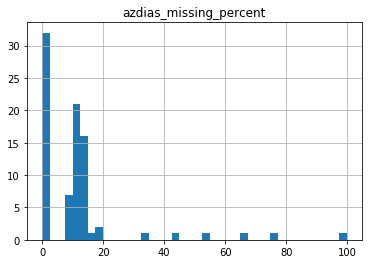

In [28]:
azdias_missing_percent_df.hist(bins = 40)

In [29]:
# Filter features missing more than 10% of data  

azdias_missing_percent_g10_df = azdias_missing_percent_df[azdias_missing_percent_df['azdias_missing_percent'] > 10.0]
azdias_missing_percent_g10_sorted_df = azdias_missing_percent_g10_df.sort_values(by=['azdias_missing_percent'], inplace=False, ascending=False)

print("Length of azdias_missing_percent > 10%: ", len(azdias_missing_percent_g10_sorted_df))
display(azdias_missing_percent_g10_sorted_df)


Length of azdias_missing_percent > 10%:  46


,azdias_missing_percent
TITEL_KZ,99.757636
AGER_TYP,76.955435
KK_KUNDENTYP,65.596749
KBA05_BAUMAX,53.468668
GEBURTSJAHR,44.020282
ALTER_HH,34.813699
REGIOTYP,17.735668
KKK,17.735668
W_KEIT_KIND_HH,16.605084
KBA05_ANTG1,14.959701


<function matplotlib.pyplot.show(*args, **kw)>

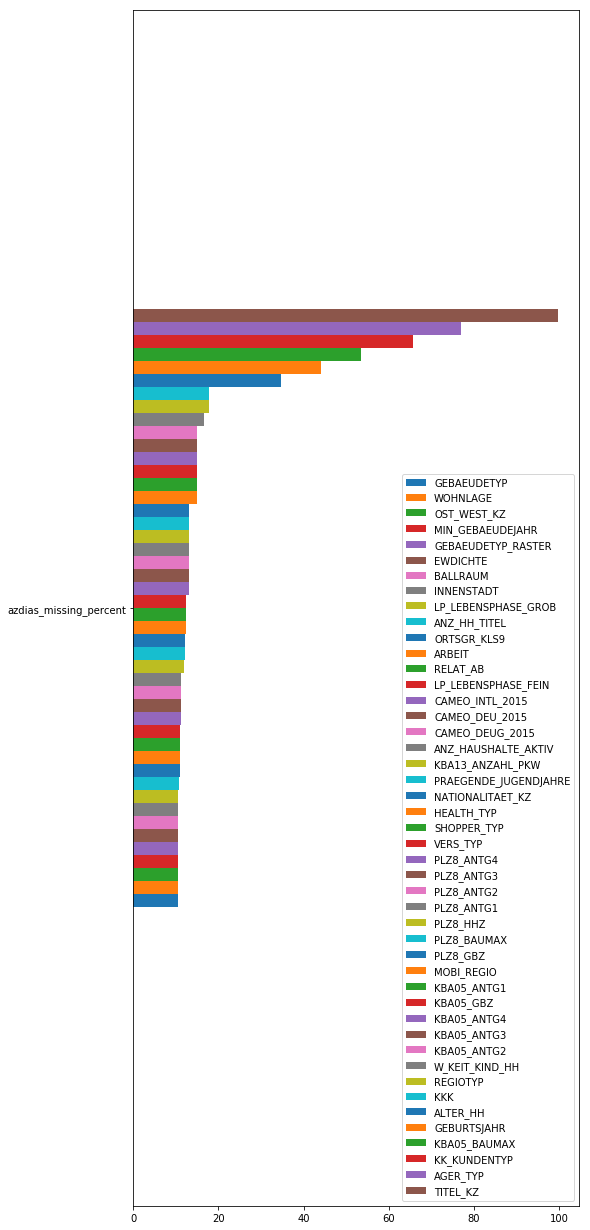

In [30]:
# Investigate patterns in amount of missing data in each column. # cmap=plt.cm.Blues

azdias_missing_percent_g10_sorted_asc_df = azdias_missing_percent_g10_df.sort_values(by=['azdias_missing_percent'], inplace=False, ascending=True)

azdias_missing_percent_g10_sorted_asc_tr_df = azdias_missing_percent_g10_sorted_asc_df.transpose()
azdias_missing_percent_g10_sorted_asc_tr_df.plot(kind='barh', figsize = (8,22))
plt.show

In [31]:

azdias_missing_percent_g20_df = azdias_missing_percent_df[azdias_missing_percent_df['azdias_missing_percent'] > 20.0]
azdias_missing_percent_g20_sorted_df = azdias_missing_percent_g20_df.sort_values(by=['azdias_missing_percent'], inplace=False, ascending=False)
display(azdias_missing_percent_g20_sorted_df)


,azdias_missing_percent
TITEL_KZ,99.757636
AGER_TYP,76.955435
KK_KUNDENTYP,65.596749
KBA05_BAUMAX,53.468668
GEBURTSJAHR,44.020282
ALTER_HH,34.813699


As evident from the plot above, 46 features contains NaN values in more than 10% of their respective columns, within these 46 columns there are 6 outliers with well over 20% of missing values which I remove from consideration moving forward.

- `TITEL_KZ`      &emsp;&emsp;&emsp; `99.76%` <br>
- `AGER_TYP`	  &emsp;&emsp;&emsp; `76.95%` <br>
- `KK_KUNDENTYP`	&emsp; `65.60%` <br>
- `KBA05_BAUMAX`	&emsp; `53.47%` <br>
- `GEBURTSJAHR`	  &emsp; `44.02%` <br>
- `ALTER_HH`	  &emsp;&emsp;&emsp; `34.81%` <br>



In [32]:
azdias_missing_percent_g20_tr_df = azdias_missing_percent_g20_df.transpose()
azdias_missing_percent_g20_tr_df

,AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX
azdias_missing_percent,76.955435,44.020282,99.757636,34.813699,65.596749,53.468668


In [33]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_missing_percent_g20_tr_df = azdias_missing_percent_g20_df.transpose()
azdias2 = azdias.drop(azdias_missing_percent_g20_tr_df, axis = 1)

#checking if columns were eliminated
print(azdias2.shape)
display(azdias2.head(n=10))


(891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,1.0,1,1.0,0.0,4.0,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,2.0,6,1.0,0.0,3.0,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,2.0,4,1.0,0.0,4.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [34]:
azdias_missing_percent_g20_tr_df.columns.values.tolist()
# feat_info_drop_idx = feat_info.isin(azdias_missing_percent_g20_tr_df.columns.values.tolist()) 
# feat_info_drop_idx[feat_info_drop_idx.attribute == True]

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [35]:
# Removing dropped features from feat_info 

# values that match dropped features names is marked as True
feat_info_drop_idx = feat_info.isin(azdias_missing_percent_g20_tr_df.columns.values.tolist()) 

# dropping rows from feat_info where corresponding row of feat_info_drop_idx is labelled True
feat_info2 = feat_info.drop(feat_info_drop_idx[feat_info_drop_idx.attribute == True].index) 

print("Dimension of new feat_info2: ", feat_info2.shape)
display(feat_info2) 


Dimension of new feat_info2:  (79, 4)


,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


For the remaining features, are there any patterns in which columns have, or share, missing data?

In [36]:
# checking patterns for features without missing values. 

azdias_missing_percent_0_df = azdias_missing_percent_df[azdias_missing_percent_df['azdias_missing_percent'] == 0]

print("Number of features without missing data: ", len(azdias_missing_percent_0_df))
display(azdias_missing_percent_0_df)

Number of features without missing data:  24


,azdias_missing_percent
ANREDE_KZ,0.0
FINANZ_MINIMALIST,0.0
FINANZ_SPARER,0.0
FINANZ_VORSORGER,0.0
FINANZ_ANLEGER,0.0
FINANZ_UNAUFFAELLIGER,0.0
FINANZ_HAUSBAUER,0.0
FINANZTYP,0.0
GREEN_AVANTGARDE,0.0
SEMIO_SOZ,0.0


As evident from the new feature summary dataframe above, there are 24 feature attributes with no missing data!

#### Discussion 1.1.2: Assess Missing Data in Each Column

Here is the brief reporting of my observations regarding the amount of missing data in each column. <br>
Are there any patterns in missing values? <br>
Which columns were removed from the dataset? <br>
For the remaining features, are there any patterns in which columns have, or share, missing data? <br>

As evident from the plots and tables above, 46 features were missing more than 10% data. And out of those 46 features there were 6 outliers with well over 30% of missing values which I removed from `AZDIAS` demographics dataset as well as `feat_info` feature summary file.

- `TITEL_KZ`	    &emsp;&emsp;&emsp; `99.76 %` <br>
- `AGER_TYP`	    &emsp;&emsp;&emsp; `76.95 %` <br>
- `KK_KUNDENTYP`	&nbsp; `65.60 %` <br>
- `KBA05_BAUMAX`	&nbsp; `53.47 %` <br>
- `GEBURTSJAHR`	    &emsp; `44.02 %` <br>
- `ALTER_HH`	    &emsp;&emsp;&emsp; `34.81 %` <br>


**As evident from the following sorted tables in terms of missing counts/percents per column, the following AZDIAS features have the same number of missing values due to overlapping nature of their measurement levels, in descending order of missing data counts:**

1) Both `REGIOTYP` (Neighborhood typology) and `KKK` (Purchasing power in region) features belong to `RR1 region/neighborhood features` measurement level where there is same/high proportion of missing data due to the fact that survey responders do not have idea about those higher-level information or at least not willing to provide such sensitive information publicly.

`REGIOTYP`	&emsp; `158064`	&emsp; `17.74%` <br>
`KKK`	&emsp;&emsp;&emsp;&emsp; `158064`	&emsp; `17.74%` <br>


2) `KBA05_*` (number of family houses/buildings) features fall under `RR3 micro-cell features` category and `MOBI_REGIO` (movement patterns in the neighborhood) feature falls under `RR1 region/neighborhood features` category. <br>
Since these questions are related to family houses/buildings and region/neighborhood where these buildings located, responders may have not enough information about that demographics and naturally leave the answers to such questions unanswered/unknown.


`KBA05_ANTG1`	&emsp; `133324`	&emsp; `14.96%` <br>
`KBA05_ANTG2`	&emsp; `133324`	&emsp; `14.96%` <br>
`KBA05_ANTG3`	&emsp; `133324`	&emsp; `14.96%` <br>
`KBA05_ANTG4`	&emsp; `133324`	&emsp; `14.96%` <br>
`KBA05_GBZ`	    &emsp;&emsp; `133324`  &emsp; `14.96%` <br>
`MOBI_REGIO`	&emsp; `133324`	&emsp; `14.96%` <br>

3) `PLZ8_*` (Number/type of family houses/households/buildings in PLZ8 region) features belong to `PLZ8 macro-cell features` category altogether and since they all measure the same type of information, they have the same number of missing data. Unsurprisingly these are the survey questions hard to find answers for from ordinary people with no access to such residential demographics information  .


`PLZ8_ANTG1`	&emsp; `116515`	&emsp; `13.07%` <br>
`PLZ8_ANTG2`	&emsp; `116515`	&emsp; `13.07%` <br>
`PLZ8_ANTG3`	&emsp; `116515`	&emsp; `13.07%` <br>
`PLZ8_ANTG4`	&emsp; `116515`	&emsp; `13.07%` <br>
`PLZ8_BAUMAX`	&emsp; `116515`	&emsp; `13.07%` <br>
`PLZ8_HHZ`	&emsp;&emsp; `116515`	&emsp; `13.07%` <br>
`PLZ8_GBZ`	&emsp;&emsp; `116515`	&emsp; `13.07%` <br>


4) These typology features are all under `Person-level features` category and hence the same number of missing data comes at no surprise given the same level of privacy residing in each measurement (shopper/insurance/health typology).


`SHOPPER_TYP`	&emsp; `111196`	&emsp; `12.48%` <br>
`VERS_TYP`	&emsp;&emsp; `111196`	&emsp; `12.48%` <br>
`HEALTH_TYP`	&emsp; `111196`	&emsp; `12.48%` <br>


5) These are all `RR4 micro-cell features` category associated with Germans Wealth / Life Stage Typology on different granularity/standard levels where the similary in terms of missing data is quite expected.


`CAMEO_INTL_2015` &emsp;   `99352`	&emsp; `11.15%` <br>
`CAMEO_DEU_2015`  &emsp;   `99352`	&emsp; `11.15%` <br>
`CAMEO_DEUG_2015` &emsp;   `99352`	&emsp; `11.15%` <br>


6) These features are all `Community-level features` out of which `RELAT_AB` and `ARBEIT` contain overlapping information about share of unemployment where the identical number of missing data is anticipated. <br>
`ORTSGR_KLS9` imparts information about the Size of community which is naturally unknown to ordinary people. 


`RELAT_AB` &emsp;&emsp;&emsp;	`97375`	&emsp; `10.93%` <br>
`ARBEIT` &emsp;&emsp;&emsp;	`97375`	&emsp; `10.93%` <br>
`ORTSGR_KLS9` &emsp;	`97274`	&emsp; `10.91%` <br>

7) All of these features fall under `Postcode-level features` category with identical missing data owing to overlapping characteristic in terms of proximity to urbal disctrict plus density of households in specific post code.

`INNENSTADT` &emsp;	`93740`	&emsp; `10.52%` <br>
`EWDICHTE`	&emsp; `93740` &emsp;	`10.52%` <br>
`BALLRAUM` &emsp;	`93740` &emsp;	`10.52%` <br>


8) Except `GEBAEUDETYP_RASTER` (Ratio of residential to commercial) which belongs to `RR1 region/neighborhood features` category, other following 4 features are under `Building-level features` with same measurement level and shared information since all measure building-level specifics and neighborhood quality; hence the same amount of missing data is normal.

`GEBAEUDETYP_RASTER` &emsp;	`93155` &emsp;	`10.45%` <br>
`MIN_GEBAEUDEJAHR` &emsp;&emsp;	`93148` &emsp;	`10.45%` <br>
`GEBAEUDETYP` &emsp;&emsp;&emsp;&emsp;&emsp;	`93148` &emsp;	`10.45%` <br>
`WOHNLAGE` &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;	`93148` &emsp;	`10.45%` <br>
`OST_WEST_KZ` &emsp;&emsp;&emsp;&emsp;&emsp;	`93148` &emsp;	`10.45%` <br>

9) These 2 are `Person-level features` that both contain family type information on different scale (fine vs. rough scale); hence overlapping information and same amount of missing data is not uncommon.

`LP_FAMILIE_FEIN` &emsp;	`77792` &emsp;	`8.73%` <br>
`LP_FAMILIE_GROB` &emsp;	`77792`	&emsp; `8.73%` <br>


10) Other than `SOHO_KZ` (Small office/home office flag) feature which belongs to `Person-level features`, the rest of the 3 features gather household member & residence length information which require same level of demographics granularity when it comes to survey responders; hence same number of missing data values.


`ANZ_PERSONEN`	&emsp; `73499` &emsp;	`8.25%` <br>
`SOHO_KZ`	&emsp;&emsp;&emsp;&emsp;&emsp; `73499` &emsp;	`8.25%` <br>
`ANZ_TITEL` &emsp;&emsp;&emsp;&emsp;	`73499` &emsp;	`8.25%` <br>
`WOHNDAUER_2008` &emsp;	`73499` &emsp;	`8.25%` <br>


11) `LP_STATUS_FEIN` & `LP_STATUS_GROB` refer to Social status on fine & rough scale, respectively where the same missing data is natural due to overlapping information. <br>

`ONLINE_AFFINITAET` (Online affinity) is under `RR1 region/neighborhood features` category, while `CJT_GESAMTTYP`, `GFK_URLAUBERTYP`, `RETOURTYP_BK_S`, all fall under the category of `Person-level features` with semantic correlation between them which make them inter-dependent so that missing data in one of them directly affects the other; therefore, same amount of missing data is organically happening!  


`CJT_GESAMTTYP`	&emsp;&emsp;&emsp; `4854` &emsp;	`0.54%` <br>
`RETOURTYP_BK_S` &emsp;&emsp;	`4854` &emsp;	`0.54%` <br>
`ONLINE_AFFINITAET` &emsp;	`4854` &emsp;	`0.54%` <br>
`LP_STATUS_FEIN` &emsp;&emsp;	`4854` &emsp;	`0.54%` <br>
`LP_STATUS_GROB` &emsp;&emsp;	`4854` &emsp;	`0.54%` <br>
`GFK_URLAUBERTYP` &emsp;&emsp;	`4854` &emsp;	`0.54%` <br>


**The following 24 AZDIAS features have no missing values and hence insights drawn from such features are more rigorous.**

The reason for such completeness of data is that all of these features are straight forward questions about financial, personality, gender, personal attitude/preference under `Person-level features` category for which answers are readily available.


`FINANZTYP`	<br>
`GREEN_AVANTGARDE`	<br>
`FINANZ_HAUSBAUER`	<br>
`FINANZ_UNAUFFAELLIGER`	<br>
`FINANZ_ANLEGER`	<br>
`FINANZ_SPARER`	<br>
`FINANZ_MINIMALIST`	<br>
`ANREDE_KZ`	<br>
`FINANZ_VORSORGER`	<br>
`SEMIO_FAM`	<br>
`SEMIO_SOZ`	<br>
`SEMIO_REL`	<br>
`SEMIO_MAT`	<br>
`SEMIO_VERT`	<br>
`SEMIO_LUST`	<br>
`SEMIO_ERL`	<br>
`SEMIO_KULT`	<br>
`SEMIO_RAT`	<br>
`SEMIO_KRIT`	<br>
`SEMIO_DOM`	<br>
`SEMIO_KAEM`	<br>
`SEMIO_PFLICHT`	<br>
`SEMIO_TRADV`	 <br>
`ZABEOTYP`	<br>

**Conclusion:** <br>
All in all, the conclusion is that some `AZDIAS` statistically-oriented features are either overlapping or unavailable information not accessible to general public; hence, corresponding questions are left unanswered.


In [37]:
# Series.sort_values(axis=0, ascending=True, inplace=False, 
# kind='quicksort', na_position='last', ignore_index=False, key=None)

# missing data count/percent per AZDIAS dataset column
print('number of azdias demographics data: ', len(azdias))

azdias_nan_count = azdias.isnull().sum() 
azdias_nan_percent = (azdias.isnull().sum() / len(azdias)) * 100

s1 = pd.Series(nat_miss, name='Naturally missing')
s2 = pd.Series(azdias_nan_count, name='Missing count after NaN-conversion')
s3 = pd.Series(azdias_nan_percent, name='Missing percent after NaN-conversion')

s2_sorted = s2.sort_values(axis=0, ascending=False, inplace=False)
s3_sorted = s3.sort_values(axis=0, ascending=False, inplace=False)

display(pd.concat([s2_sorted, s3_sorted], axis=1))


# azdias_missing_number = (azdias.isnull().sum(axis=0)
# azdias_missing_percent = (azdias.isnull().sum(axis=0) / len(azdias)) * 100
# # type(azdias_missing_percent)

# azdias_missing_number_df = pd.DataFrame(azdias_missing_number, columns = ['azdias_missing_number'])  
# azdias_missing_percent_df = pd.DataFrame(azdias_missing_percent, columns = ['azdias_missing_percent'])
                     
# azdias_missing_number_sorted_df = azdias_missing_number_df.sort_values(by=['azdias_missing_number'], inplace=False, ascending=False)
# azdias_missing_percent_sorted_df = azdias_missing_percent_df.sort_values(by=['azdias_missing_percent'], inplace=False, ascending=False)


# print("Length of azdias_missing_percent: ", len(azdias_missing_percent_df))
# display(azdias_missing_percent_df)


number of azdias demographics data:  891221


,Missing count after NaN-conversion,Missing percent after NaN-conversion
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
REGIOTYP,158064,17.735668
KKK,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG4,133324,14.959701


In [38]:
# print("Length of azdias_missing_percent > 10%: ", len(azdias_missing_percent_g10_sorted_df))
# display(azdias_missing_percent_g10_sorted_df)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [39]:
# How much data is missing in each row of the dataset?

rows_mis = pd.DataFrame(azdias2.isnull().sum(axis=1), columns=['missing_in_rows'])
display(rows_mis.head(n=10))
print("Length of rows_mis dataframe: ", len(rows_mis))

,missing_in_rows
0,43
1,0
2,0
3,7
4,0
5,0
6,0
7,0
8,0
9,0


Length of rows_mis dataframe:  891221


In [40]:
# general statistics on AZDIAS demographics missing data by row 
rows_mis.describe()

,missing_in_rows
count,891221.000000
mean,5.649894
std,13.234687
min,0.000000
25%,0.000000
50%,0.000000
75%,3.000000
max,49.000000


As evident from the statistics above, on average about 6 data values are missing in each row. Also,
75% of data rows are missing 3 data values.  

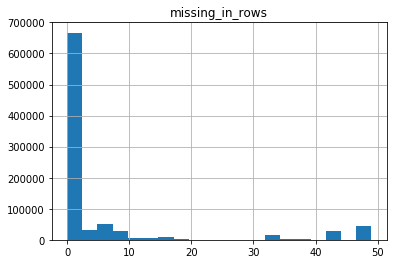

In [41]:
rows_mis.hist(bins=20); #  rcParams["hist.bins"] (default: 10)

As visible from the missing-per-row data histogram above, by dividing dataset based on number of missings per row, data can be splitted into 2 subsets: <br>

1) missing-per-row <= 20 values <br>
2) missing-per-row > 20 values <br>


In [42]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Add a column to the AZDIAS demographics dataset showing number of missing values in each row

azdias2_r = azdias2.join(rows_mis) 
display(azdias2_r.head(n=10))


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_in_rows
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0
7,1.0,1,3.0,3,3,4,1,3,2,5,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,1.0,1,1.0,0.0,4.0,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0
8,3.0,1,3.0,4,4,2,4,2,2,6,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,2.0,6,1.0,0.0,3.0,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0
9,3.0,2,4.0,2,4,2,3,5,4,1,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,2.0,4,1.0,0.0,4.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0


In [43]:
azdias2_r_le20 = azdias2_r[azdias2_r['missing_in_rows']<=20]
azdias2_r_g20 = azdias2_r[azdias2_r['missing_in_rows']>20]


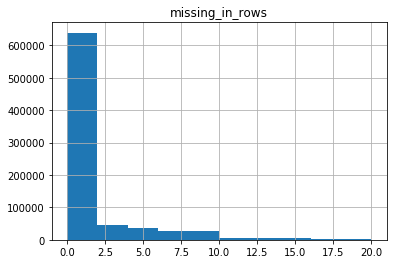

In [44]:
# histogram with number of missing values <=20
azdias2_r_le20.hist(column='missing_in_rows');

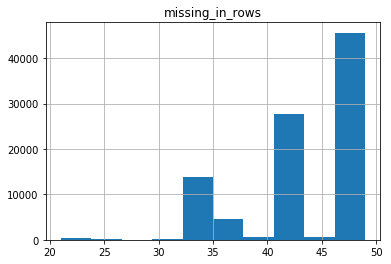

In [45]:
# histogram with number of missing values >20
azdias2_r_g20.hist(column='missing_in_rows');

In [46]:

def compare_per_col(row_few_missing_df, row_many_missing_df, col):
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6)) # default value is [8.0, 6.0] 
    sns.countplot(row_few_missing_df[col], ax=ax[0]).set(title='Few or no missing values')
    sns.countplot(row_many_missing_df[col], ax=ax[1]).set(title='Many missing values')
    plt.subplots_adjust(wspace=1)
    fig.show()
    return

# Create a bar plot visualization
# fig, ax = plt.subplots(figsize = (14,8))

Length of azdias_missing_percent < 10%:  39


,azdias_missing_percent
LP_FAMILIE_FEIN,8.728699
LP_FAMILIE_GROB,8.728699
KONSUMNAEHE,8.299737
WOHNDAUER_2008,8.247000
ANZ_TITEL,8.247000
ANZ_PERSONEN,8.247000
SOHO_KZ,8.247000
HH_EINKOMMEN_SCORE,2.058749
ONLINE_AFFINITAET,0.544646
LP_STATUS_FEIN,0.544646


<function matplotlib.pyplot.show(*args, **kw)>

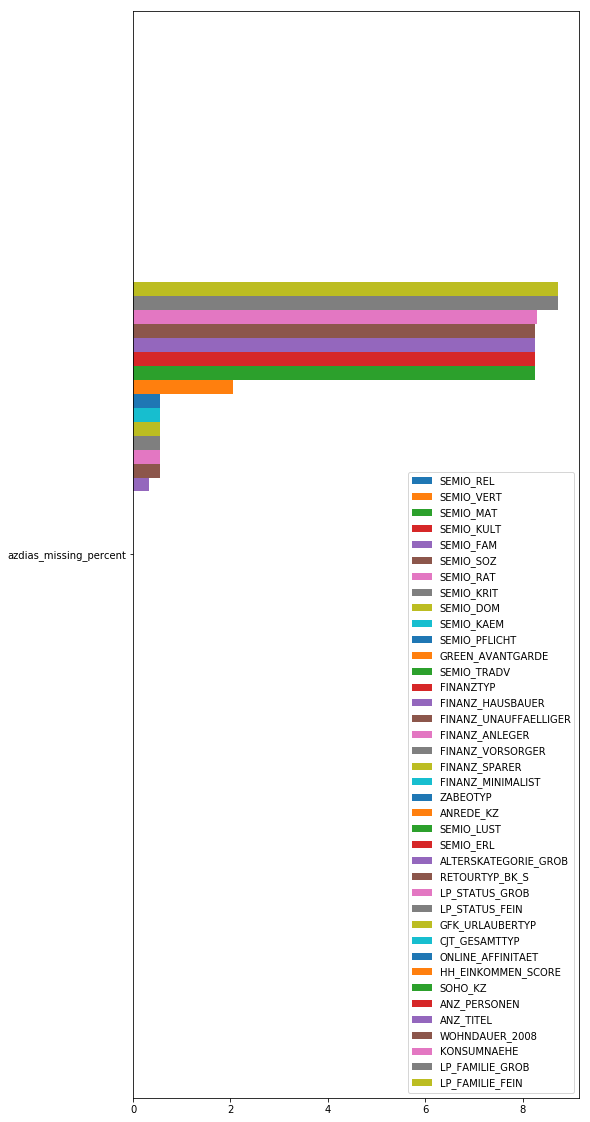

In [47]:
# Filter features no or few missing values (<10%)  

azdias_missing_percent_l10_df = azdias_missing_percent_df[azdias_missing_percent_df['azdias_missing_percent'] < 10.0]
azdias_missing_percent_l10_sorted_df = azdias_missing_percent_l10_df.sort_values(by=['azdias_missing_percent'], inplace=False, ascending=False)

print("Length of azdias_missing_percent < 10%: ", len(azdias_missing_percent_l10_sorted_df))
display(azdias_missing_percent_l10_sorted_df)

azdias_missing_percent_l10_sorted_asc_df = azdias_missing_percent_l10_df.sort_values(by=['azdias_missing_percent'], inplace=False, ascending=True)
azdias_missing_percent_l10_sorted_asc_tr_df = azdias_missing_percent_l10_sorted_asc_df.transpose()
azdias_missing_percent_l10_sorted_asc_tr_df.plot(kind='barh', figsize = (8,20))
plt.show


In [48]:

letters = ['a', 'b', 'c', 'd', 'e', 'f']
random_index = random.randint(0, len(letters)-1)

print(letters[random_index])

a


In [49]:
# Filter features no or few missing values (<1%)  
azdias_missing_percent_l1_df = azdias_missing_percent_df[azdias_missing_percent_df['azdias_missing_percent'] < 1.0]
azdias_missing_percent_l1_sorted_df = azdias_missing_percent_l1_df.sort_values(by=['azdias_missing_percent'], inplace=False, ascending=False)
# display(azdias_missing_percent_l1_sorted_df)

azdias_missing_percent_l1_sorted_tr_df = azdias_missing_percent_l1_sorted_df.transpose()
few_no_missing_cols = azdias_missing_percent_l1_sorted_tr_df.columns.values.tolist()
print("length of few_no_missing_cols(<1%): ", len(few_no_missing_cols))
few_no_missing_cols


length of few_no_missing_cols(<1%):  31


['ONLINE_AFFINITAET',
 'GFK_URLAUBERTYP',
 'CJT_GESAMTTYP',
 'RETOURTYP_BK_S',
 'LP_STATUS_GROB',
 'LP_STATUS_FEIN',
 'ALTERSKATEGORIE_GROB',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'ZABEOTYP',
 'SEMIO_TRADV',
 'SEMIO_PFLICHT',
 'SEMIO_KAEM',
 'SEMIO_DOM',
 'SEMIO_KRIT',
 'SEMIO_RAT',
 'SEMIO_KULT',
 'SEMIO_ERL',
 'SEMIO_LUST',
 'SEMIO_VERT',
 'SEMIO_MAT',
 'SEMIO_REL',
 'SEMIO_FAM',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'GREEN_AVANTGARDE',
 'FINANZ_ANLEGER',
 'FINANZTYP',
 'SEMIO_SOZ']

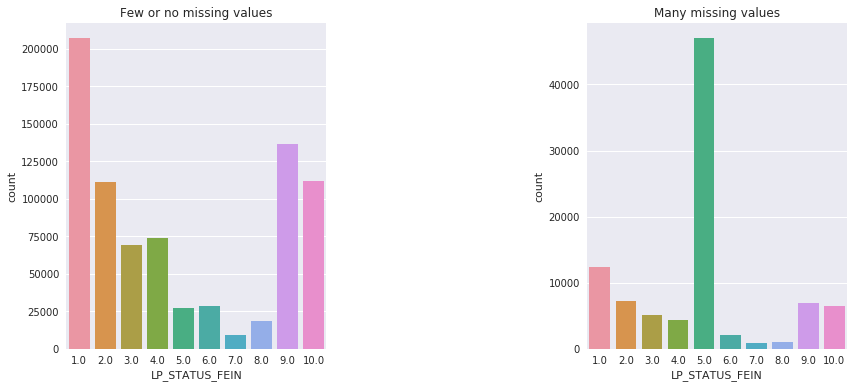

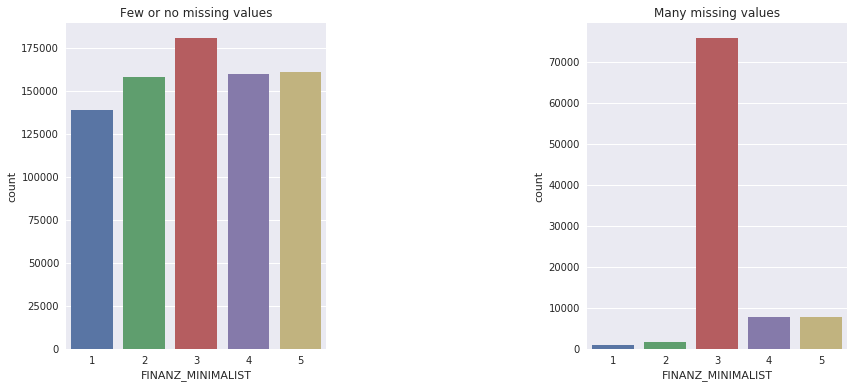

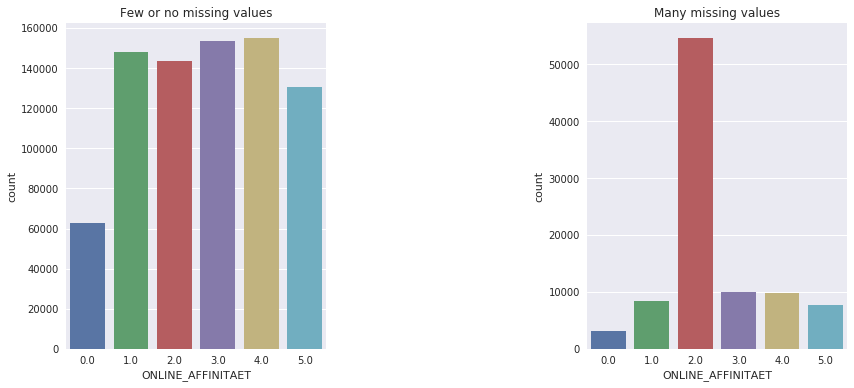

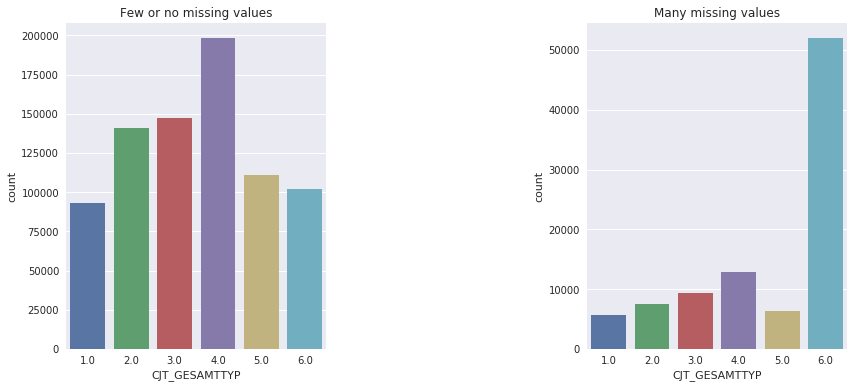

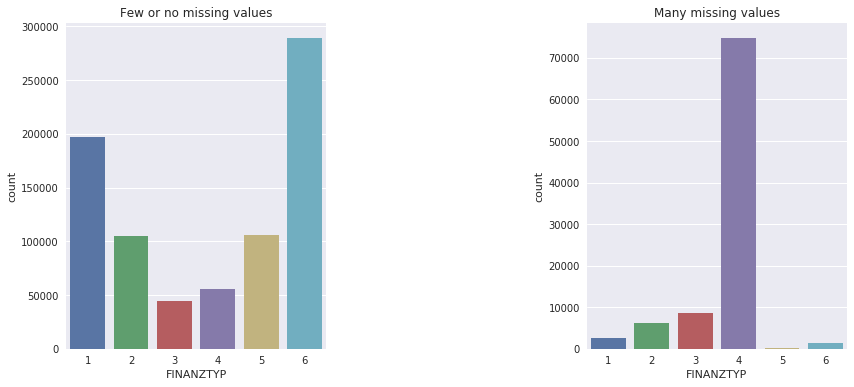

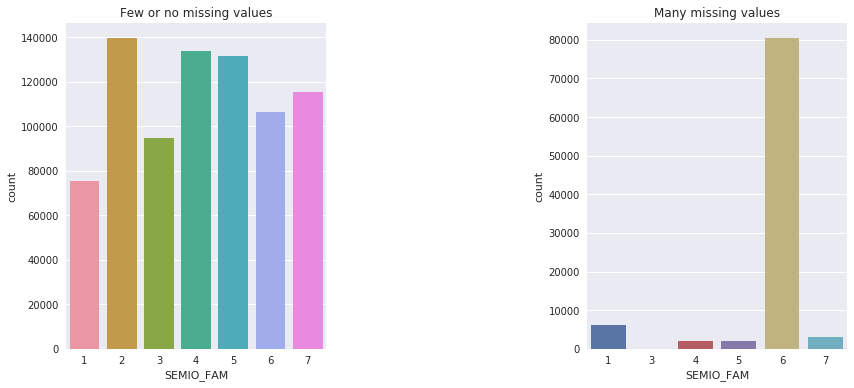

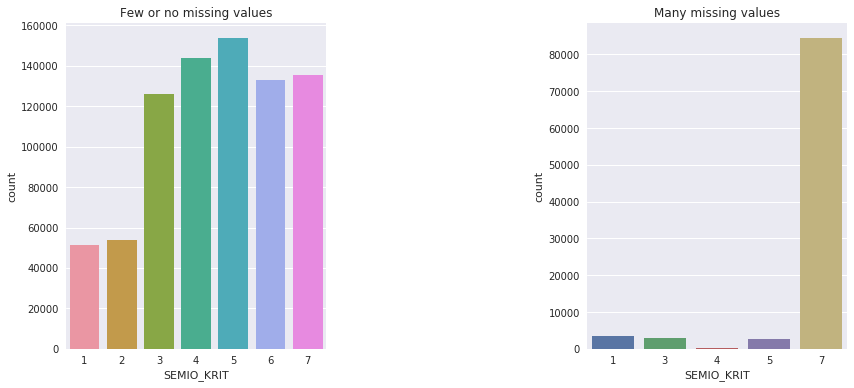

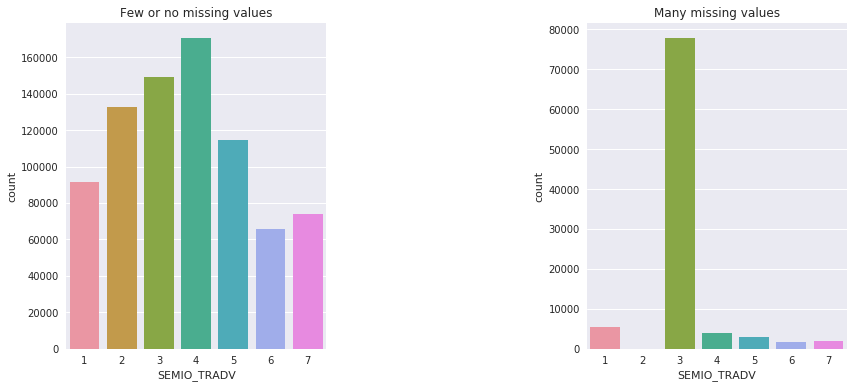

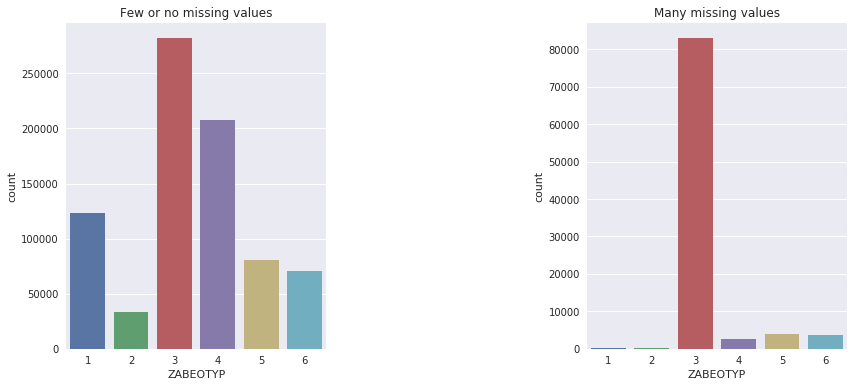

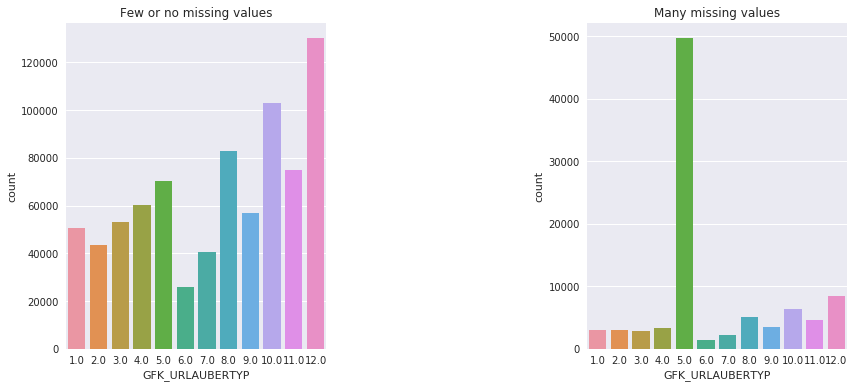

In [50]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

sns.set(style="darkgrid")
for i in range(10):
    random_index = random.randint(0, len(few_no_missing_cols)-1)
    compare_per_col(azdias2_r_le20, azdias2_r_g20, few_no_missing_cols[random_index])
    

# compare_per_col(azdias2_r_le20, azdias2_r_g20, 'ALTERSKATEGORIE_GROB')

In [51]:
# dropping rows that contains > 10 missing values and saving rows which contains <=10 missing values.
azdias3 = azdias2_r[azdias2_r['missing_in_rows']<=10]

azdias3 = azdias3.drop('missing_in_rows', axis = 1)  

print("AZDIAS size after dropping missing_in_rows>10: " , azdias3.shape)
display(azdias3.head(n=10))

AZDIAS size after dropping missing_in_rows>10:  (780153, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,1.0,1,1.0,0.0,4.0,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,2.0,6,1.0,0.0,3.0,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,2.0,4,1.0,0.0,4.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2,1.0,2,2,5,3,1,5,6,8.0,0,2.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,5.0,5,2,3,5,5,6,6,1,4,7,4,7,5,3,2.0,0.0,2.0,3,1.0,0.0,6.0,6.0,9.0,6.0,0.0,1.0,4.0,1992.0,W,5.0,9,9D,51,0.0,4.0,1.0,0.0,2.0,6.0,4.0,4.0,5.0,4.0,1.0,1.0,7.0,424.0,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


In [52]:
display(azdias3.head(n=10))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,1.0,4,1.0,0.0,6.0,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,1.0,1,1.0,0.0,4.0,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,2.0,6,1.0,0.0,3.0,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,2.0,4,1.0,0.0,4.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2,1.0,2,2,5,3,1,5,6,8.0,0,2.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,3.0,5.0,5,2,3,5,5,6,6,1,4,7,4,7,5,3,2.0,0.0,2.0,3,1.0,0.0,6.0,6.0,9.0,6.0,0.0,1.0,4.0,1992.0,W,5.0,9,9D,51,0.0,4.0,1.0,0.0,2.0,6.0,4.0,4.0,5.0,4.0,1.0,1.0,7.0,424.0,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.3: Assess Missing Data in Each Row

`Question: Are the data with lots of missing values are qualitatively different from data with few or no missing values?)`


Based on the results of the missing-per-row data histogram, I splitted AZDIAS dataset based on the number of missings per row into 2 subsets:

1) missing-per-row <= 20 values <br>
2) missing-per-row > 20 values <br>

where according to the histogram the majority of rows miss values <= 20.

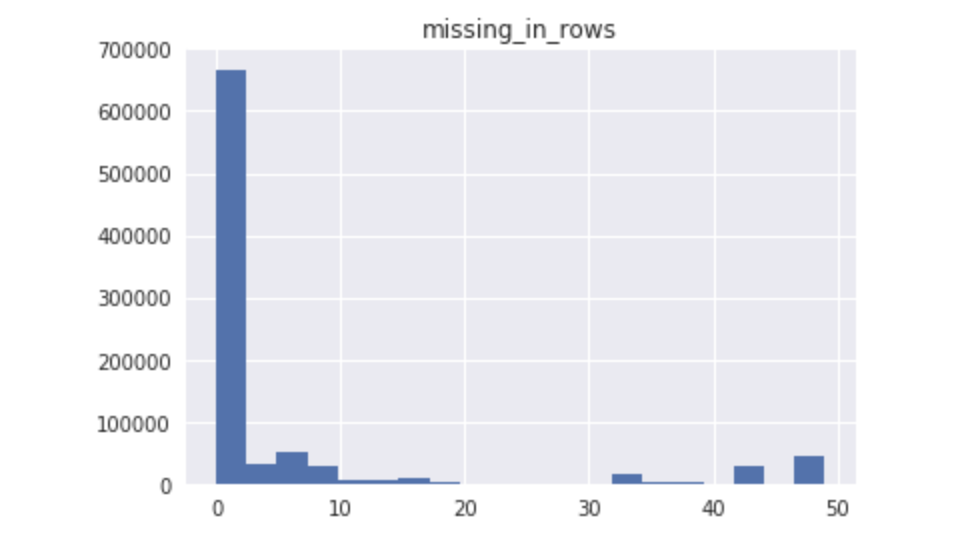

As seen in the preceding statement, I plotted distributions of the non-missing features for comparison between the data with many missing values (>20) and the data with few/no missing values (<=20). Here are some of the findings to illustrate my points.

I qualitatively compare the resultant distribution curves (compare the relative heights of the corresponding bars in each plot to see if they follow the same pattern) between the 2 subsets after splitting, and if they follow the same pattern, it is safe to drop the subset with many missing vales altogether from the analysis, and keep both subsets otherwise.

For instance in the screenshot below for `ANREDE_KZ` feature, both subsets exhibit the same pattern in terms of relative heights of the bars between 1(male) and 2(female) values (in both plots female Gender data are more missing than male missing data; hence higher the female bars). Hence, in this case I may decide to drop the subset with "many missing values" since simply dropping those points from the analysis will not present a major issue.

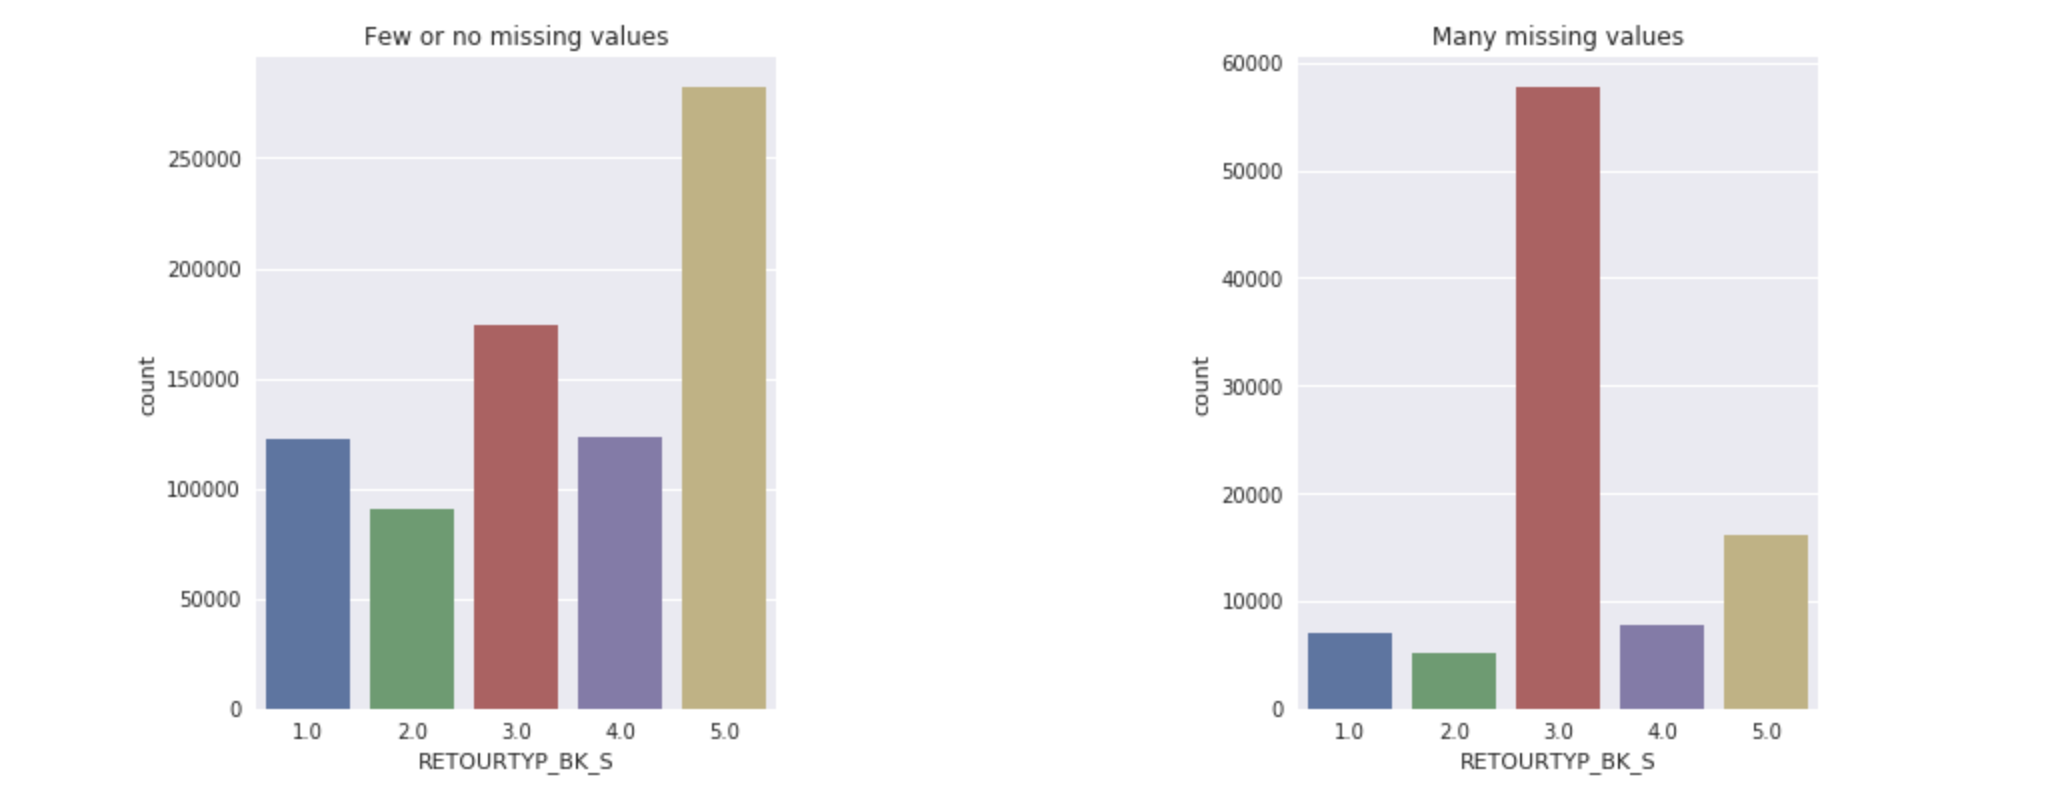

In contrast, in case of `RETOURTYP_BK_S` feature, the distributions of data values between the 2 subsets follow different patterns. In simpler words, relative heights of the corresponding categories are not the same (For instance highest bar is in different category between the 2 subsets). Hence, in this case we make a note on these data as special and revisit such data later on.

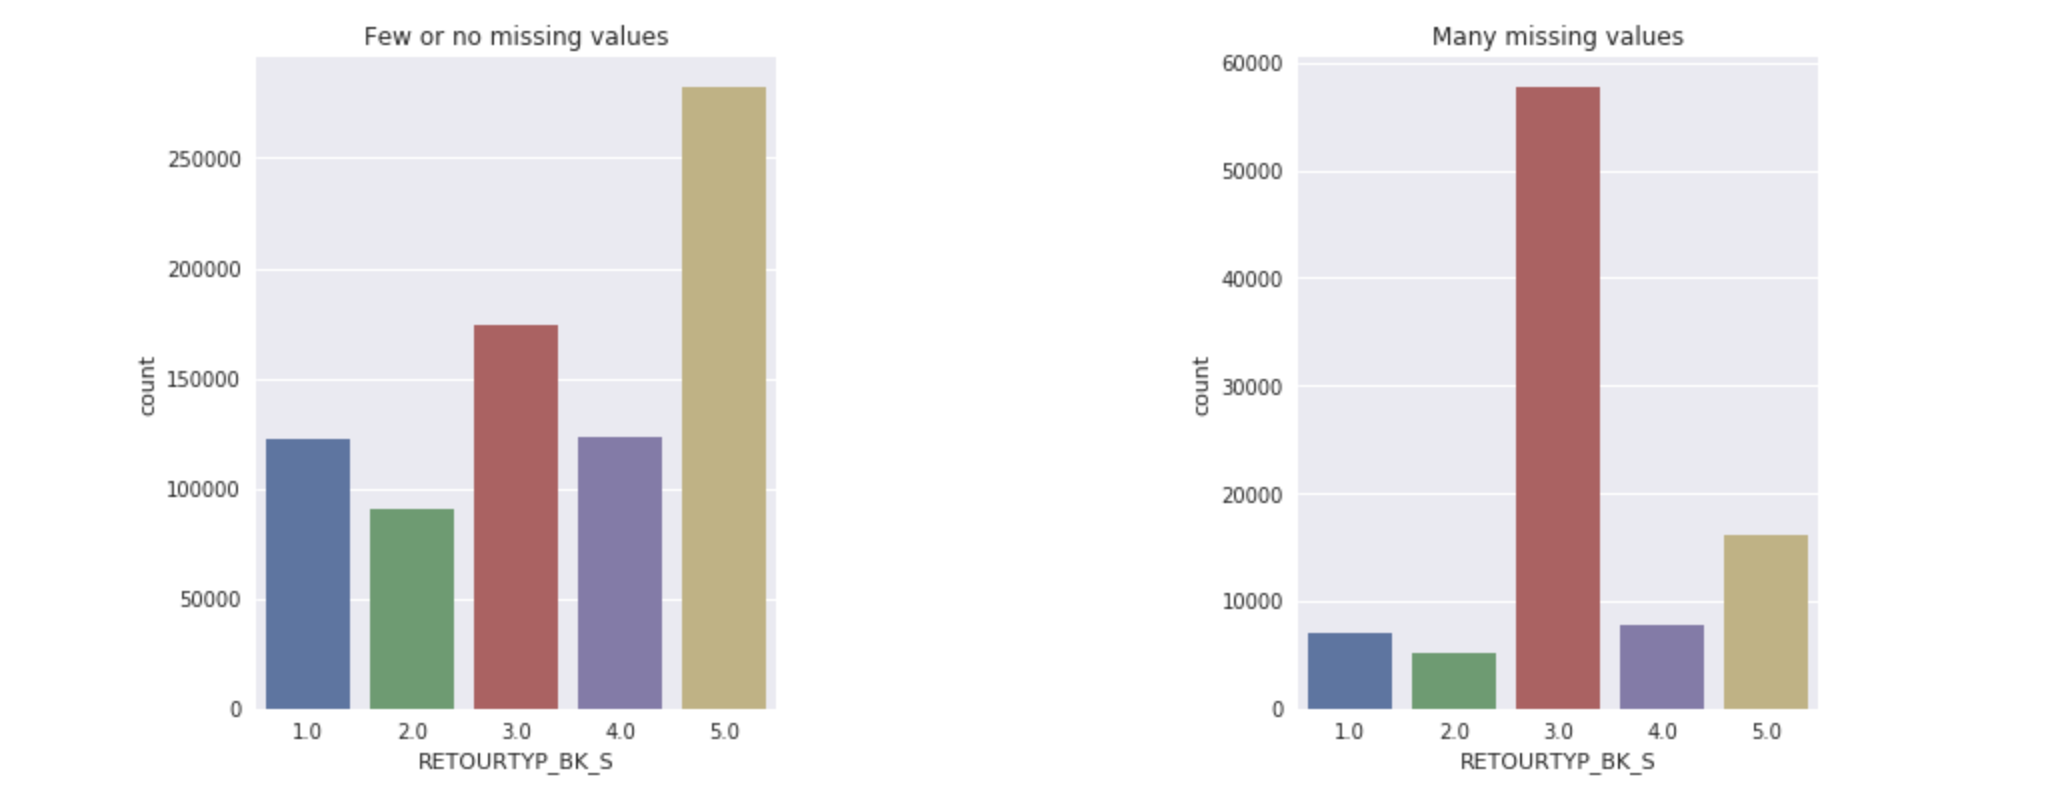

All in all, I observed that except `ANREDE_KZ` feature, in the remaining 8 out of 9 unique feature countplots, the distributions of data values between the 2 subsets follow different patterns: <br>
Different pattern features: `FINANZ_UNAUFFAELLIGER`, `FINANZ_SPARER`, `SEMIO_SOZ`, `FINANZTYP`, `FINANZ_ANLEGER`, `LP_STATUS_GROB`, `SEMIO_PFLICHT`, `SEMIO_VERT`; <br>

Either way, I continue my analysis for now using just the subset of the data with few or no missing values.

As per the histogram visualization, the range of [10 30] looks suitable for splitting the AZDIAS data based on the missing values across the rows.

To be more on the conservative side, I have decided that only rows with missing values <=10 will be furtherly used in the analysis as more than that thresold might bring false result and bias, since anyhow missing values should be imputed with other values not from the original data source.



### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [53]:
feat_info2

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


In [54]:
# How many features are there of each data type?

num_feat = feat_info2.type.value_counts()
display(num_feat)

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

As visible above, there are 18 categorical features!

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [55]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_feat = feat_info2[feat_info2['type']=='categorical']
display(cat_feat)

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [56]:
cat_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 2 to 58
Data columns (total 4 columns):
attribute             18 non-null object
information_level     18 non-null object
type                  18 non-null object
missing_or_unknown    18 non-null object
dtypes: object(4)
memory usage: 720.0+ bytes


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


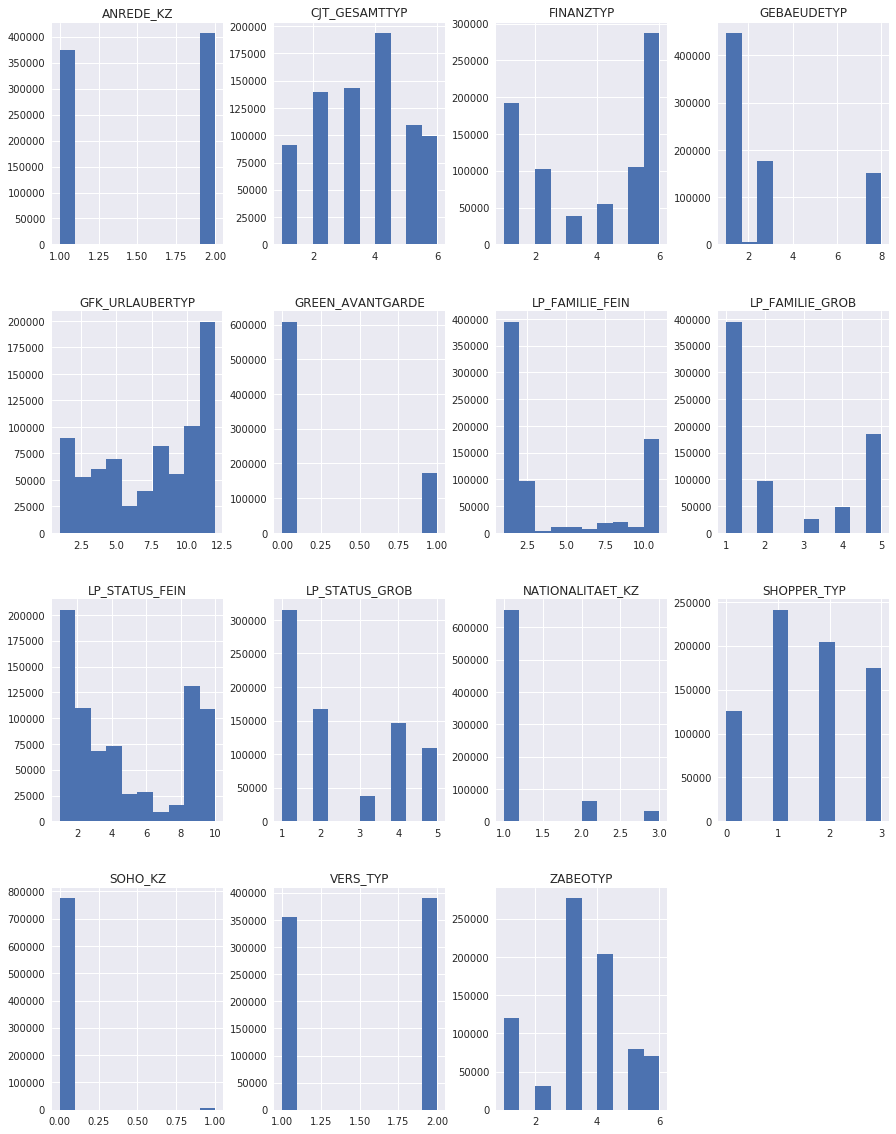

In [57]:
# identifying numeric & non-numeric categorical features 
# warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
azdias3[cat_feat['attribute']].hist(ax = ax);

As evident from the foregoing histogram, all but Building-level `OST_WEST_KZ` feature are numeric categorical features; hence they show up in the histogram plots. <br>
`OST_WEST_KZ` feature is a non-numeric categorical feature and consequently does not show up in the histogram plot above as is (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html), and needs to be plotted separately.

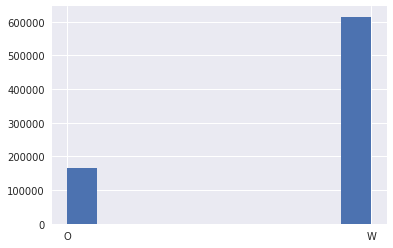

In [58]:
# "OST_WEST_KZ" feature contains non-numeric categorical values
azdias3['OST_WEST_KZ'].hist();

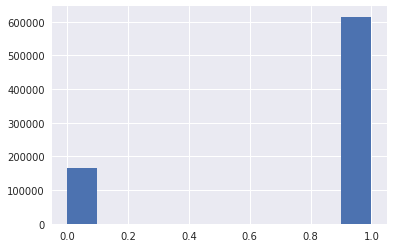

In [59]:
# replacing str 'O' and 'W' with 0 and 1, respectively

azdias3.OST_WEST_KZ = azdias3.OST_WEST_KZ.replace({'O': 0.0,'W': 1.0})  

# plot histogram
azdias3['OST_WEST_KZ'].hist();

In [60]:
# filtering list of categorical features for one-hot encoding via pandas.get_dummies
multi_cat_list = [] 

for column in cat_feat['attribute']:
    # print(column) # feature name
    cat_unique_value = azdias3[column].unique() # returns list of unique values
    print(column, ": ", cat_unique_value) 
    if cat_unique_value.size > 2: # we only need features containing more than 2 possible values
        multi_cat_list.append(column)

ANREDE_KZ :  [2 1]
CJT_GESAMTTYP :  [  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP :  [1 6 5 2 4 3]
GFK_URLAUBERTYP :  [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
GREEN_AVANTGARDE :  [0 1]
LP_FAMILIE_FEIN :  [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB :  [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN :  [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB :  [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ :  [  1.   3.   2.  nan]
SHOPPER_TYP :  [  3.   2.   1.   0.  nan]
SOHO_KZ :  [ 1.  0.]
VERS_TYP :  [  2.   1.  nan]
ZABEOTYP :  [5 3 4 1 6 2]
GEBAEUDETYP :  [ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ :  [ 1.  0.]
CAMEO_DEUG_2015 :  ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015 :  ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' 

In [61]:
# print(azdias3['OST_WEST_KZ'].unique().size)
print(multi_cat_list) # for these features we need to apply one-hot encoding via pandas.get_dummies

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [62]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias4 = pd.get_dummies(azdias3, columns=multi_cat_list)
print(azdias4.shape)
display(list(azdias4.columns))

(780153, 195)


['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 

In [63]:
display(azdias4.head(n=10))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,

#### Discussion 1.2.1: Re-Encode Categorical Features

`Question: Which ones did you keep, which did you drop, and what engineering steps did you perform?`

I keep binary categoricals of numeric type as is. <br>
For one binary variable of non-numeric type `OST_WEST_KZ`, I replaced `O` and `W` characters with numeric values of `0` and `1`, respectively. <br>
For multi-level categorical features (>2 levels), I have used `pandas.get_dummies` converter (Convert categorical variable into dummy/indicator variables) without dropping the features so as not to miss any potential highly-predictive variable.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [64]:
# 6 mixed type features

cat_feat_mix = feat_info2[feat_info2['type']=='mixed']
display(cat_feat_mix)

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [65]:
# review unique valies of mixed-type features

for column in cat_feat_mix['attribute']:
    mixed_cat_unique_value = azdias4[column].unique() # mixed type feature unique values
    print(column, ": ", mixed_cat_unique_value, "\n") 
    

LP_LEBENSPHASE_FEIN :  [ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.  25.
  13.  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.  39.
  27.  36.   9.  34.  33.  15.  11.  40.  16.  19.  17.] 

LP_LEBENSPHASE_GROB :  [  6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   4.   8.] 

PRAEGENDE_JUGENDJAHRE :  [ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.] 

WOHNLAGE :  [ 4.  2.  7.  3.  5.  1.  8.  0.] 

CAMEO_INTL_2015 :  ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25' nan
 '23' '31' '52' '35' '45' '44' '32'] 

PLZ8_BAUMAX :  [  1.   2.  nan   4.   5.   3.] 



In [66]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Divide "PRAEGENDE_JUGENDJAHRE" into 2 variables: 
# 1) an interval-type variable for decade: (40s, 50s, ..., 90s)
# 2) binary variable for movement: Avantgarde vs. Mainstream

# copy column "PRAEGENDE_JUGENDJAHRE" to 2 new columns: 
# 1) PRAEGENDE_JUGENDJAHRE_DEC (Decades) 
# 2) PRAEGENDE_JUGENDJAHRE_MOV (Avantgarde vs. Mainstream) 

# Original PRAEGENDE_JUGENDJAHRE values will be dropped 

azdias4['PRAEGENDE_JUGENDJAHRE_DEC'] = azdias4['PRAEGENDE_JUGENDJAHRE']
azdias4['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias4['PRAEGENDE_JUGENDJAHRE']

In [67]:
# Mapping PRAEGENDE_JUGENDJAHRE_DEC and PRAEGENDE_JUGENDJAHRE_MOV

dict_dec =  {1: 40.0, 2: 40.0, 
             3: 50.0, 4: 50.0,
             5: 60.0, 6: 60.0, 7: 60.0,
             8: 70.0, 9: 70.0,
             10: 80.0, 11: 80.0, 12: 80.0, 13: 80.0,
             14: 90.0, 15: 90.0}


# replacing with decade values
azdias4.PRAEGENDE_JUGENDJAHRE_DEC = azdias4.PRAEGENDE_JUGENDJAHRE_DEC.replace(dict_dec)  


# encoding Mainstream & Avantgarde as 0 & 1, respectively
dict_mov =  {1: 0.0, 2: 1.0,
             3: 0.0, 4: 1.0,
             5: 0.0, 6: 1.0, 7: 1.0,
             8: 0.0, 9: 1.0,
             10: 0.0, 11: 1.0,
             12: 0.0, 13: 1.0,
             14: 0.0, 15: 1.0}



azdias4.PRAEGENDE_JUGENDJAHRE_MOV = azdias4.PRAEGENDE_JUGENDJAHRE_MOV.replace(dict_mov)  

In [68]:
cat_feat_mix[cat_feat_mix['attribute']=='PRAEGENDE_JUGENDJAHRE']['attribute']

22    PRAEGENDE_JUGENDJAHRE
Name: attribute, dtype: object

In [69]:
# display(azdias4[cat_feat_mix['attribute']].head(n=10))
azdias4[ cat_feat_mix[cat_feat_mix['attribute']=='PRAEGENDE_JUGENDJAHRE']['attribute'] ].head(n=10)

,PRAEGENDE_JUGENDJAHRE
1,14.0
2,15.0
3,8.0
4,8.0
5,3.0
6,10.0
7,8.0
8,11.0
9,15.0
10,3.0


In [70]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Divide "CAMEO_INTL_2015" into 2 new engineered features: 
# 1) Wealth stage: CAMEO_INTL_2015_W

# Wealthy Households: 1
# Prosperous Households: 2
# Comfortable Households: 3
# Less Affluent Households: 4
# Poorer Households: 5


# 2) Life stage: CAMEO_INTL_2015_L

# Pre-Family: 1
# Young Couples: 2
# Families: 3
# Older Families: 4
# Elders: 5

# copy "CAMEO_INTL_2015" to 2 new columns: CAMEO_INTL_2015_W & CAMEO_INTL_2015_L
azdias4['CAMEO_INTL_2015_W'] = azdias4['CAMEO_INTL_2015']
azdias4['CAMEO_INTL_2015_L'] = azdias4['CAMEO_INTL_2015']


In [71]:
azdias4[0: 10]['CAMEO_INTL_2015'].values

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '51'], dtype=object)

In [72]:
# Encoding CAMEO_INTL_2015_W and CAMEO_INTL_2015_L

# CAMEO_INTL_2015 values are all object type

# mapping Wealth stage codes
dict_wealth = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,
               '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,
               '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,
               '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,
               '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 5.0}

azdias4.CAMEO_INTL_2015_W = azdias4.CAMEO_INTL_2015_W.replace(dict_wealth) 


# mapping Life Stage codes
dict_life = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,
             '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,
             '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,
             '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,
             '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}

azdias4.CAMEO_INTL_2015_L = azdias4.CAMEO_INTL_2015_L.replace(dict_life) 


In [73]:
cat_feat_mix

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [74]:
azdias4[ cat_feat_mix[cat_feat_mix['attribute']=='CAMEO_INTL_2015']['attribute'] ].head(n=10)

,CAMEO_INTL_2015
1,51
2,24
3,12
4,43
5,54
6,22
7,14
8,13
9,15
10,51


#### Discussion 1.2.2: Engineer Mixed-Type Features

`Reporting my findings and decisions regarding mixed-value features. Which ones did I keep, which did I drop, and what engineering steps did I perform?`


+ `PRAEGENDE_JUGENDJAHRE` - re-encoded to 2 new features:  

 
1) `PRAEGENDE_JUGENDJAHRE_DEC`: an interval-type variable for decade: (40s, 50s, ..., 90s) <br>
2) `PRAEGENDE_JUGENDJAHRE_MOV`: binary variable for movement: Avantgarde vs. Mainstream <br>


+ `CAMEO_INTL_2015` - re-encoded to 2 new Wealth & Life stage features:  

1) Wealth stage: `CAMEO_INTL_2015_W` = {Wealthy Households: 1, Prosperous Households: 2, Comfortable Households: 3, Less Affluent Households: 4, Poorer Households: 5} <br>
2) Life stage: `CAMEO_INTL_2015_L` = {Pre-Family: 1, Young Couples: 2, Families: 3, Older Families: 4, Elders: 5}


+ `LP_LEBENSPHASE_FEIN` (Life stage, fine scale): contains multiple phases of Person-level life/socioeconomic status as: single/couple/family, age, income, homeowners, single parent. 
Due to high number of mixed granularity, I do not see any value in creating new dummy variables for each and every aspect of this mixed feature other than unnecessarily complicating the cluster analysis process; hence, I keep this feature as is, to avoid losing predictive power of life/socioeconomic status with respect to customer data clustering.


+ `LP_LEBENSPHASE_GROB` (Life stage, rough scale): similar to `LP_LEBENSPHASE_FEIN` but in a rough granular scale, this mixed feature contains multiple phases of Person-level life/socioeconomic status as: single/couple/family, age, income, homeowners, single parent. 
Again, Due to high number of mixed granularity, I do not see any value in creating new dummy variables for each and every aspect of this mixed feature other than unnecessarily complicating the cluster analysis process; hence, I keep this feature as is, to avoid losing predictive power of life/socioeconomic status with respect to customer data clustering.


+ `WOHNLAGE` (Neighborhood quality (or rural flag)): 
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

Since there is no clear boundary between the subjective qualitative levels (e.g. good vs. very good) of this feature, it does not lend itself well to PCA analysis which is a category-oriented process; therefore, `WOHNLAGE` is dropped from analysis moving forward.


+ `PLZ8_BAUMAX` (Most common building type within the PLZ8 region): 
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes  -->  `PLZ8_ANTG1`
-  2: mainly 3-5 family homes  -->  `PLZ8_ANTG2`
-  3: mainly 6-10 family homes  -->  `PLZ8_ANTG3`
-  4: mainly 10+ family homes  -->  `PLZ8_ANTG4`
-  5: mainly business buildings

Again, there is a vague breakdown for this feature where "mainly" interpretation is open for debate; moreover, the quantitative measurement of this feature with corresponding levels of granularity (except business buildings) is already present as 4 separate features of `PLZ8_ANTG1`, `PLZ8_ANTG2`, `PLZ8_ANTG3`, `PLZ8_ANTG4` in the same `PLZ8 macro-cell features` category.

Hence, due to qualitative nature of this mixed feature besides overlapping with other already-present quantitative features, I drop `PLZ8_BAUMAX` feature without detracting from quality of PCA clustering analysis.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [75]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

## All eligible features are already re-engineered.

In [76]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# dropping original columns substituted by engineered features and irrelevant/overlapping features
azdias4.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace=True)

display(azdias4.head(n=10))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MOV,CAMEO_INTL_2015_W,CAMEO_INTL_2015_L
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,90.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,

In [77]:
print("dataframe selected/re-encoded dimensions: ", azdias4.shape)

dataframe selected/re-encoded dimensions:  (780153, 195)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [78]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Identify missing or unknown data values and convert them to NaNs.
    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)

    # remove selected columns and rows, ...
    df_missing_percent = (df.isnull().sum(axis=0) / len(df)) * 100
    df_missing_percent_df = pd.DataFrame(df_missing_percent, columns = ['df_missing_percent'])
    # Remove the outlier columns from the dataset (perform other data engineering tasks such as imputation later)
    df_missing_percent_g20_df = df_missing_percent_df[df_missing_percent_df['df_missing_percent'] > 20.0]
    df_missing_percent_g20_tr_df = df_missing_percent_g20_df.transpose()
    df2 = df.drop(df_missing_percent_g20_tr_df, axis = 1)

    # How much data is missing in each row of the dataset?
    rows_mis = pd.DataFrame(df2.isnull().sum(axis=1), columns=['missing_in_rows'])
    df2_r = df2.join(rows_mis) 
    # dropping rows that contains > 10 missing values
    df3 = df2_r[df2_r['missing_in_rows']<=10]
    df3 = df3.drop('missing_in_rows', axis = 1) 

    # select, re-encode, and engineer column values.
    # Re-Encode Categorical Features
    cat_feat = feat_info2[feat_info2['type']=='categorical']

    df3.OST_WEST_KZ = df3.OST_WEST_KZ.replace({'O': 0.0,'W': 1.0})  
    # filtering list of categorical features for one-hot encoding via pandas.get_dummies
    multi_cat_list = [] 

    for column in cat_feat['attribute']:
        cat_unique_value = df3[column].unique() # returns list of unique values
        if cat_unique_value.size > 2: # we only need features containing more than 2 possible values
            multi_cat_list.append(column)

    # Re-encode categorical variable(s) to be kept in the analysis.
    df4 = pd.get_dummies(df3, columns=multi_cat_list)

    # Engineer Mixed-Type Features
    cat_feat_mix = feat_info2[feat_info2['type']=='mixed']
    for column in cat_feat_mix['attribute']:
        mixed_cat_unique_value = df4[column].unique() # mixed type feature unique values

    df4['PRAEGENDE_JUGENDJAHRE_DEC'] = df4['PRAEGENDE_JUGENDJAHRE']
    df4['PRAEGENDE_JUGENDJAHRE_MOV'] = df4['PRAEGENDE_JUGENDJAHRE']

    # Mapping PRAEGENDE_JUGENDJAHRE_DEC and PRAEGENDE_JUGENDJAHRE_MOV
    dict_dec =  {1: 40.0, 2: 40.0, 
                 3: 50.0, 4: 50.0,
                 5: 60.0, 6: 60.0, 7: 60.0,
                 8: 70.0, 9: 70.0,
                 10: 80.0, 11: 80.0, 12: 80.0, 13: 80.0,
                 14: 90.0, 15: 90.0}


    # replacing with decade values
    df4.PRAEGENDE_JUGENDJAHRE_DEC = df4.PRAEGENDE_JUGENDJAHRE_DEC.replace(dict_dec)  


    # encoding Mainstream & Avantgarde as 0 & 1, respectively
    dict_mov =  {1: 0.0, 2: 1.0,
                 3: 0.0, 4: 1.0,
                 5: 0.0, 6: 1.0, 7: 1.0,
                 8: 0.0, 9: 1.0,
                 10: 0.0, 11: 1.0,
                 12: 0.0, 13: 1.0,
                 14: 0.0, 15: 1.0}

    df4.PRAEGENDE_JUGENDJAHRE_MOV = df4.PRAEGENDE_JUGENDJAHRE_MOV.replace(dict_mov)  

    # copy "CAMEO_INTL_2015" to 2 new columns: CAMEO_INTL_2015_W & CAMEO_INTL_2015_L
    df4['CAMEO_INTL_2015_W'] = df4['CAMEO_INTL_2015']
    df4['CAMEO_INTL_2015_L'] = df4['CAMEO_INTL_2015']

    # Encoding CAMEO_INTL_2015_W and CAMEO_INTL_2015_L
    # mapping Wealth stage codes
    dict_wealth = {'11': 1.0, '12': 1.0, '13': 1.0, '14': 1.0, '15': 1.0,
                   '21': 2.0, '22': 2.0, '23': 2.0, '24': 2.0, '25': 2.0,
                   '31': 3.0, '32': 3.0, '33': 3.0, '34': 3.0, '35': 3.0,
                   '41': 4.0, '42': 4.0, '43': 4.0, '44': 4.0, '45': 4.0,
                   '51': 5.0, '52': 5.0, '53': 5.0, '54': 5.0, '55': 5.0}

    df4.CAMEO_INTL_2015_W = df4.CAMEO_INTL_2015_W.replace(dict_wealth) 

    # mapping Life Stage codes
    dict_life = {'11': 1.0, '12': 2.0, '13': 3.0, '14': 4.0, '15': 5.0,
                 '21': 1.0, '22': 2.0, '23': 3.0, '24': 4.0, '25': 5.0,
                 '31': 1.0, '32': 2.0, '33': 3.0, '34': 4.0, '35': 5.0,
                 '41': 1.0, '42': 2.0, '43': 3.0, '44': 4.0, '45': 5.0,
                 '51': 1.0, '52': 2.0, '53': 3.0, '54': 4.0, '55': 5.0}

    df4.CAMEO_INTL_2015_L = df4.CAMEO_INTL_2015_L.replace(dict_life) 

    # dropping original columns substituted by engineered features and irrelevant/overlapping features
    df4.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'WOHNLAGE', 'PLZ8_BAUMAX'], axis=1, inplace=True)

    # Return the cleaned dataframe.
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [79]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = Imputer(missing_values=np.nan, strategy='median', axis = 0)
azdias4_imp = pd.DataFrame(imputer.fit_transform(azdias4))

In [89]:
azdias4_imp.columns = azdias4.columns # restoring original column names
azdias4_imp.index = azdias4.index # restoring original indices

In [90]:
azdias4_imp.shape

(780153, 195)

In [91]:
azdias4_imp.head(n=10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MOV,CAMEO_INTL_2015_W,CAMEO_INTL_2015_L
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,21.0,6.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.

In [92]:
azdias4_imp.isnull().sum(axis=0) # columnar nan checking

ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
HEALTH_TYP                   0
LP_LEBENSPHASE_FEIN          0
LP_LEBENSPHASE_GROB          0
RETOURTYP_BK_S               0
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
SEMIO_RAT                    0
SEMIO_KRIT                   0
SEMIO_DOM                    0
SEMIO_KAEM                   0
SEMIO_PFLICHT                0
SEMIO_TRADV                  0
SOHO_KZ                      0
ANZ_PERSONEN                 0
ANZ_TITEL                    0
HH_EINKOMMEN_SCORE           0
W_KEIT_KIND_HH               0
WOHNDAUE

In [93]:
# azdias4_imp.isnull().sum(axis=1) # row-wise nan checking

In [94]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler() 
azdias4_scaled = pd.DataFrame(scaler.fit_transform(azdias4_imp))

azdias4_scaled.columns = azdias4_imp.columns # restoring original column names
azdias4_scaled.index = azdias4_imp.index # restoring original indices

display(azdias4_scaled.head(n=10)) # verifying result

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MOV,CAMEO_INTL_2015_W,CAMEO_INTL_2015_L
1,-1.767651,0.958395,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,-0.531199,1.088920,0.412206,0.317534,-1.682495,0.434451,-0.057434,0.005086,-0.454614,-1.685168,-1.120989,-1.436709,-0.583197,1.277558,-0.306355,1.336372,-0.157888,1.505994,1.290984,10.871068,0.229631,-0.060808,1.011783,-0.680170,0.553949,0.165102,-0.125740,-1.299636,-0.391262,0.518769,-1.067825,-1.025045,-0.603111,2.699386,-1.644964,0.847880,-0.552845,1.704189,-0.796820,-0.786177,-1.396806,0.180522,-0.852117,1.019323,-0.258308,0.213255,0.406412,0.410201,1.426834,0.563767,-0.174147,-0.132852,0.679557,-0.364118,-0.466914,-0.475014,-0.574297,2.477561,-0.381123,1.746373,-0.388468,-0.228232,-0.275520,-0.393503,-0.762754,-0.262003,-0.231283,-0.269681,-0.289025,-0.313572,-0.183799,-0.232496,-0.342342,-0.277202,2.588532,-0.323445,-0.437839

In [95]:
print("azdias4_scaled dimensions: ", azdias4_scaled.shape)

azdias4_scaled dimensions:  (780153, 195)


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
# Apply PCA to the data.



In [ ]:
# Investigate the variance accounted for by each principal component.



In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.



### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.



In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.



In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.



### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = 

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.